# DeepDock example

This notebook is an example of how to do molecular docking using DeepDock. We show how to prepare the target to to generate a mesh file and how to use it for docking.

### Target mesh generation

Load required libraries for target mesh generation

In [1]:
from deepdock.prepare_target.computeTargetMesh import compute_inp_surface
import trimesh

RDKit WARNING: [12:35:45] Enabling RDKit 2019.09.1 jupyter extensions


Copy data from deepdock installation folder (deepdock/data)

In [2]:
import deepdock 
copy_pdb = 'cp '+deepdock.__path__[0]+'/../data/1z6e_protein.pdb .'
copy_mol2 = 'cp '+deepdock.__path__[0]+'/../data/1z6e_ligand.mol2 .'
!$copy_pdb
!$copy_mol2

Define the file with the PDB of the target and the mol2 file of the co-crystalized ligand. 

In [3]:
basename = '1z6e_protein'
target_filename = basename+'.pdb' 
ligand_filename = '1z6e_ligand.mol2'

Compute the target mesh. This will create a .ply file that contains the mesh information and a pdb that defines a the binding site around the co-crystalized ligand

In [4]:
compute_inp_surface(target_filename, ligand_filename, dist_threshold=10)

You can visualize the target mesh with the following commands

In [5]:
mesh = trimesh.load_mesh(basename+'.ply')
print('Number of nodes: ', len(mesh.vertices))
mesh.show()

Number of nodes:  743


### Binding conformation prediction usign DeepDock

Load required libraries for docking

In [5]:
from rdkit import Chem
import deepdock
from deepdock.models import *
from deepdock.DockingFunction import dock_compound, get_random_conformation

import numpy as np
import torch
# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)

Define the DeepDock model to use

In [6]:
device = 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

Load pretrained model.

In [7]:
checkpoint = torch.load(deepdock.__path__[0]+'/../Trained_models/DeepDock_pdbbindv2019_13K_minTestLoss.chk', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

Define the path to the .ply file containing the target mesh and load the ligand as RDKIT ligand. Molecule can be loaded from any file type or smiles as long it is readable by RDKIT. It is recommended to start from a 3D molecule with all isomers defined. If starting from a SMILES the code will generate 3D coordinates and minimize them usign MMFF94. 

**Important:** As with every docking software, DeepDock is very susceptible to ligand preparation. In general we recommend to use the same ligand preparation steps that were used to prepare the training data, in this case PDBbind. If that is not possible, at lease use mol2 produced by Corina for compound containg chemical groups with conjugated bonds (eg. carboxylates, phosphates, sulphates, etc) since bond deffinition can change and can have great impact on results.


In [8]:
target_ply = '1z6e_protein.ply'
real_mol = Chem.MolFromMol2File('1z6e_ligand.mol2',sanitize=False, cleanupSubstructures=False)

The following compound computes the ligand binding conformation usign DeepDock. It returns the optimized molecule and the results from differential evolution algorithm

            fun: array([-258.85778592])
            jac: array([-1.69022309e+02,  1.71047907e+02, -1.14398853e+02,  5.30523039e+01,
        6.62718094e+00, -3.20072161e+01,  8.05214995e+01,  1.03612922e+02,
        9.26440066e+01,  1.17157697e+00, -4.24169684e+01, -2.28344220e+01,
        9.42156930e-01,  1.19297283e-01])
        message: 'Optimization terminated successfully.'
           nfev: 49853
            nit: 316
 num_MixOfGauss: 517
      num_atoms: 38
   num_rotbonds: 8
       rotbonds: [(14, 15, 7, 8), (22, 9, 21, 4), (23, 22, 9, 21), (8, 17, 20, 0), (7, 19, 21, 4), (29, 28, 25, 24), (28, 32, 34, 35), (32, 34, 35, 36)]
        success: True
              x: array([-0.99374445, -2.56988637, -3.12112576, 10.60745797, 27.68033189,
       56.43378115, -1.93031307,  0.15773386, -0.30088624, -1.9763511 ,
       -0.61640145,  0.54661285,  2.04593077,  0.16918374])


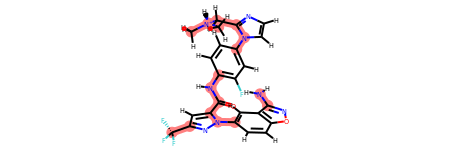

In [9]:
opt_mol, init_mol, result = dock_compound(real_mol, target_ply, model, dist_threshold=3., popsize=150, seed=123, device='cpu')
print(result)
opt_mol

**Results** \
fun: negative Score of the predicted molecule \
jac: \
message: Indicates if optimization finished correctly \
nfev: 42666 \
nit: number of iterations used to converge \
num_MixOfGauss: Number of mixture of guassians used to score the final molecule \
num_atoms: Number of heavy atoms in theligand \
num_rotbonds: Number of rotatable bonds in the ligand \
rotbonds: Rotatable bond in the ligand \
success: True or Fail depending if the optimization converged \
x: Final values to transform original molecule into the oenn with predicted binding conformation

You can visualize the bound ligand to the target using py3Dmol. This cell show code to visualze the predicted molecule (gray) and the co-crystalized molecule (red) and the starting conformation used by DeepDock (blue). 

In [10]:
import py3Dmol
p = py3Dmol.view(width=400,height=400)
with open('1z6e_protein.pdb') as ifile:
    target = "".join([x for x in ifile])
p.addModelsAsFrames(target)
p.addModel(Chem.MolToMolBlock(real_mol),'sdf')
p.addModel(Chem.MolToMolBlock(opt_mol),'sdf')
p.addModel(Chem.MolToMolBlock(init_mol),'sdf')

tar = {'model':0}
lig_real = {'model':1}
lig_opt = {'model':2}
lig_init = {'model':3}

p.setStyle(tar, {'cartoon': {'color':'gray'}})
#p.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, res)
p.setStyle(lig_real,{'stick':{'color':'red'}})
p.setStyle(lig_init,{'stick':{'color':'blue'}})
p.setStyle(lig_opt,{'stick':{}})

p.zoomTo()
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol